In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix

### 1. データ読み込み

In [2]:
df = pd.read_csv("../ks-projects-201801.csv")

In [3]:
# 訓練データとテストデータを分ける
df = df[df["state"] != "live"]
df["state"] = df["state"]=="successful"
X = df[:].values
y = df["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

### 2. 学習データ生成用の関数定義

In [4]:
# ログ出力関数
def PrintLog(log):
    #print(log)
    return

#### 訓練データ、テストデータをDataFrameに変換して返す関数

In [5]:
def ConvertDataFrame(p_x_data):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 必要なカラムだけ抜き出す
    df_x_data = pd.DataFrame({"name":p_x_data[:, 1],
                            "category":p_x_data[:, 2],
                            "main_category":p_x_data[:, 3],
                            "currency":p_x_data[:, 4],
                            "deadline":p_x_data[:, 5],
                            "launched":p_x_data[:, 7],
                            "country":p_x_data[:, 11],
                            "usd_goal_real":p_x_data[:, 14]},
                            columns=["name", "category", "main_category", "currency", "deadline", 
                                    "launched", "country", "usd_goal_real"])
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return df_x_data

#### 特徴量を追加したDataFrameを返す関数

In [6]:
def AddFeature(p_df_x_data):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 成功率が高い国か、そうでないかのカラムを追加(33%をしきい値とする)
    country_index = (p_df_x_data["country"] == "US") | \
                    (p_df_x_data["country"] == "GB") | \
                    (p_df_x_data["country"] == "CA") | \
                    (p_df_x_data["country"] == "FR") | \
                    (p_df_x_data["country"] == "SE") | \
                    (p_df_x_data["country"] == "NZ") | \
                    (p_df_x_data["country"] == "DK") | \
                    (p_df_x_data["country"] == "HK") | \
                    (p_df_x_data["country"] == "SG") | \
                    (p_df_x_data["country"] == "LU")
    p_df_x_data.loc[country_index, "country_success_rate_class"] = 1
    p_df_x_data.loc[~country_index, "country_success_rate_class"] = 0
        
    # カテゴリ別で成功率が低位の層、中間の層、上位の層を分けるカラムを追加する
    # 低位層：成功率40%未満、中間層：40%以上 60%未満、上位層：60%以上
    cate_high_index = (p_df_x_data["main_category"] == "Dance") | \
                    (p_df_x_data["main_category"] == "Theater") | \
                    (p_df_x_data["main_category"] == "Comics")
    cate_low_index = (p_df_x_data["main_category"] == "Publishing") | \
                    (p_df_x_data["main_category"] == "Photography") | \
                    (p_df_x_data["main_category"] == "Fasion") | \
                    (p_df_x_data["main_category"] == "Food") | \
                    (p_df_x_data["main_category"] == "Crafts") | \
                    (p_df_x_data["main_category"] == "journalism") | \
                    (p_df_x_data["main_category"] == "Technology")
    # 上位層
    p_df_x_data.loc[cate_high_index, "main_category_success_rate_class"] = 2
    # 中位層
    p_df_x_data.loc[~(cate_high_index | cate_low_index), "main_category_success_rate_class"] = 1
    # 下位層
    p_df_x_data.loc[cate_low_index, "main_category_success_rate_class"] = 0
    
    # クラウドファンディング期間
    launched_time = pd.to_datetime(p_df_x_data["launched"], format = "%Y-%m-%d %H:%M:%S")
    deadline_time = pd.to_datetime(p_df_x_data["deadline"], format = "%Y-%m-%d %H:%M:%S")
    p_df_x_data["term_days"] = (deadline_time - launched_time).dt.days
    
    # クラウドファンディング立ち上げ月
    p_df_x_data["launched_month"] = np.array(pd.to_datetime(p_df_x_data["launched"]).dt.month)
    # クラウドファンディング締め切り月
    p_df_x_data["deadline_month"] = np.array(pd.to_datetime(p_df_x_data["deadline"]).dt.month)
    
    # 「name」列のポジティブワードが含まれているか
    positive_word_index = ((p_df_x_data["name"].str.contains("New", na = False)) |
                            (p_df_x_data["name"].str.contains("new", na = False)) |
                            (p_df_x_data["name"].str.contains("Debut", na = False)) |
                            (p_df_x_data["name"].str.contains("First", na = False)))
    p_df_x_data.loc[positive_word_index, "positive_word"] = True
    p_df_x_data.loc[~positive_word_index, "positive_word"] = False
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return p_df_x_data

#### 前処理

In [351]:
def PreProcess(p_df_x_train, p_df_x_test):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 「usd_goal_real」は見やすいように対数変換する
    p_df_x_train["usd_goal_real"] = np.log10(p_df_x_train["usd_goal_real"].values.astype(np.float64) + 1)
    p_df_x_test["usd_goal_real"] = np.log10(p_df_x_test["usd_goal_real"].values.astype(np.float64) + 1)
    
    # Label Encode
    le = LabelEncoder()
    #for col in ["category", "main_category", "country", "currency"]:
    for col in ["category", "country"]:
        p_df_x_train["%s_class"%col] = le.fit_transform(p_df_x_train[col])
        p_df_x_test["%s_class"%col] = le.transform(p_df_x_test[col])
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return p_df_x_train, p_df_x_test

#### 学習用データの作成

In [352]:
def GetLearningData(p_x_train, p_x_test):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # DataFrameに変換
    df_x_train = ConvertDataFrame(p_x_train)
    df_x_test = ConvertDataFrame(p_x_test)
    
    # 特徴量追加
    df_x_train = AddFeature(df_x_train)
    df_x_test = AddFeature(df_x_test)

    # 前処理(データ標準化、ラベルエンコード)
    df_x_train, df_x_test = PreProcess(df_x_train, df_x_test)
    
    # 不要なカラムを削除
    for col in ["name", "category", "main_category", "currency", "deadline", "launched", "country"]:
        df_x_train = df_x_train.drop(col, axis = 1)
        df_x_test = df_x_test.drop(col, axis = 1)
            
    print("トレーニングデータ")
    display(df_x_train.head())
    display(df_x_train.tail())
    print("テストデータ")
    display(df_x_test.head())
    display(df_x_test.tail())
        
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        
    return df_x_train[:].values, df_x_test[:].values

### 3. 学習データ作成

In [353]:
# 学習データ生成クラスでデータ作成
X_train, X_test = GetLearningData(X_train, X_test)

トレーニングデータ


,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word,category_class,country_class
0,3.699057,1.0,1.0,29,6,7,False,55,22
1,4.301052,1.0,1.0,59,10,12,False,93,22
2,4.176120,1.0,1.0,29,8,9,False,113,22
3,4.176120,1.0,2.0,59,7,8,False,26,22
4,4.301052,1.0,0.0,31,8,10,False,44,22


,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word,category_class,country_class
300684,3.763503,1.0,1.0,29,9,10,False,7,22
300685,3.019366,0.0,1.0,20,11,12,False,30,0
300686,2.375499,1.0,1.0,11,11,11,False,148,3
300687,2.954725,1.0,1.0,9,1,1,False,98,22
300688,4.727558,1.0,0.0,24,8,8,False,145,20


テストデータ


,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word,category_class,country_class
0,4.477136,1.0,1.0,59,6,8,False,109,22
1,4.079217,1.0,1.0,30,10,11,False,113,22
2,3.699057,1.0,1.0,29,10,11,False,55,22
3,4.469837,1.0,0.0,50,10,12,False,103,22
4,3.903144,1.0,1.0,29,7,8,False,136,22


,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word,category_class,country_class
75168,3.875119,1.0,1.0,25,10,10,False,129,22
75169,3.518646,1.0,1.0,30,3,4,False,14,22
75170,3.903144,1.0,1.0,34,11,12,True,125,22
75171,4.128270,1.0,0.0,29,6,7,False,95,22
75172,2.700444,1.0,0.0,29,7,8,False,115,9


In [354]:
len(X_train)

300689

In [355]:
# 適当にデータを絞る
import random

random.seed(1234)
# 抽出行
index = random.sample(range(len(X_train)), k = int(len(X_train) * 0.5)) # 50%抽出
# データランダム抽出
#X_train = X_train[index, :]
#y_train = y_train[index]

len(X_train)

300689

### 4. 学習

score= 0.6975446391454293
[0.21161226 0.03123497 0.06193408 0.21674133 0.04309447 0.00858997
 0.0137698  0.38345945 0.02956367]


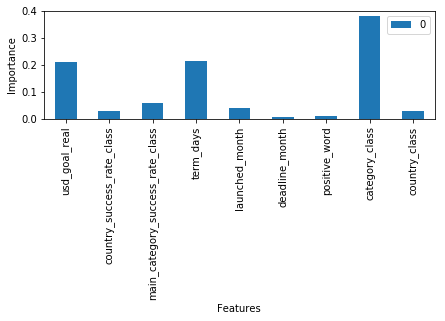

Wall time: 11 s


In [356]:
%%time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ランダムフォレスト
#clf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion="gini",
#                                                 min_samples_leaf=12, min_samples_split=4, random_state=1234)
# アダブースト
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf = 14,
                                                    min_samples_split = 2, 
                                                    random_state=1234,
                                                    criterion="gini"),
                                                       n_estimators=22, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=['usd_goal_real', 'country_success_rate_class',
       'main_category_success_rate_class', 'term_days', 'launched_month',
       'deadline_month', 'positive_word', 'category_class',
       'country_class']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 5. 評価

In [359]:
# ラベルを予測
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# 表示
print("対数尤度 = {:.3f}".format(- log_loss(y_test, y_pred)))
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

対数尤度 = -10.453
Accuracy(正答率) = 69.735%
Precision(適合率) = 60.452%
Recall(再現率) = 42.743%
F1-score(F1値) = 50.078%


In [358]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                            index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,41011,7465
正解 = successful,15286,11411
